# Лабораторная работа №8

### Вариант №7

In [13]:
import plotly.graph_objects as go
from math import *
import numpy as np
import matplotlib.pyplot as plt

def f(x, y, t, a=1, b=1, mu1=1, mu2=1):
  return 0

def phi_1(y, t, a=1, mu1=1, mu2=1):
    return cos(mu2 * y) * exp(-(mu1**2 + mu2**2) * a * t)

def phi_2(y, t, a=1, mu1=1, mu2=1):
    return (-1)**mu1 * cos(mu2 * y) * exp(-(mu1**2 + mu2**2) * a * t)

def phi_3(x, t, a=1, mu1=1, mu2=1):
    return cos(mu1 * x) * exp(-(mu1**2 + mu2**2) * a * t)

def phi_4(x, t, a=1, mu1=1, mu2=1):
    return (-1)**mu2 * cos(mu1 * x) * exp(-(mu1**2 + mu2**2) * a * t)

def psi(x, y, mu1=1, mu2=1):
    return cos(mu1 * x) * cos(mu2 * y)

def solution(x, y, t, a=1, mu1=1, mu2=1):
    return cos(mu1 * x) * cos(mu2 * y) * exp(-(mu1**2 + mu2**2) * a * t)

l_1 = pi
l_2 = pi
T = 1

N_x = 50
N_y = 50
K = 100

a = 1
b = a

alpha_1 = 0
beta_1 = 1

alpha_2 = 0
beta_2 = 1

alpha_3 = 0 
beta_3 = 1

alpha_4 = 0
beta_4 = 1

graphics = True

def get_analytical_solution(
    x_range,
    y_range,
    t_range,
    h_x,
    h_y,
    tau,
    a,
    mu1,
    mu2,
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    t = np.arange(*t_range, tau)
    res = np.zeros((len(t), len(x), len(y)))
    for idt in range(len(t)):
      for idx in range(len(x)):
        for idy in range(len(y)):
            res[idt][idx][idy] = solution(x[idx], y[idy], t[idt], a=a, mu1=mu1, mu2=mu2)

    return res

def max_abs_error(A, B):
    return abs(A - B).max()

def mean_abs_error(A, B):
    return abs(A - B).mean()

In [14]:
def tridiagonal_solve(A, b):
    n = len(A)
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n-1):
        v[i] = A[i][i+1] / (-A[i][i] - A[i][i-1] * v[i-1])
        u[i] = (A[i][i-1] * u[i-1] - b[i]) / (-A[i][i] - A[i][i-1] * v[i-1])
    v[n-1] = 0
    u[n-1] = (A[n-1][n-2] * u[n-2] - b[n-1]) / (-A[n-1][n-1] - A[n-1][n-2] * v[n-2])

    x = [0 for _ in range(n)]
    x[n-1] = u[n-1]
    for i in range(n-1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]
    return np.array(x)

def compute_D_1i(res, x, y, t, cur_x_id, cur_y_id, cur_t_id, tau, h_y, a, b, gamma, n, f, mu1, mu2):
    return (
        res[cur_x_id][cur_y_id] * (1 + gamma) / tau +
        b * gamma / (n - 1) *
            (res[cur_x_id][cur_y_id + 1] - 2 * res[cur_x_id][cur_y_id] + res[cur_x_id][cur_y_id - 1]) / h_y**2 +
        gamma / (n - 1) * f(x[cur_x_id], y[cur_y_id], t[cur_t_id] + tau / 2, a, b, mu1, mu2) +
        1 / n * (1 - gamma / (n - 1)) * f(x[cur_x_id], y[cur_y_id], t[cur_t_id], a, b, mu1, mu2)
    )


def compute_D_2j(res_fraction, x, y, t, cur_x_id, cur_y_id, cur_t_id, tau, h_x, a, b, gamma, n, f, mu1, mu2):
    return (
        res_fraction[cur_x_id][cur_y_id] * (1 + gamma) / tau +
        a * gamma / (n - 1) *
            (res_fraction[cur_x_id + 1][cur_y_id] - 2 * res_fraction[cur_x_id][cur_y_id] + res_fraction[cur_x_id - 1][cur_y_id]) / h_x**2 +
        gamma / (n - 1) * f(x[cur_x_id], y[cur_y_id], t[cur_t_id] + tau / 2, a, b, mu1, mu2) +
        1 / n * (1 - gamma / (n - 1)) * f(x[cur_x_id], y[cur_y_id], t[cur_t_id + 1], a, b, mu1, mu2)
    )

In [15]:
def finite_difference_schema_general_view(
    x_range,
    y_range,
    t_range,
    h_x,
    h_y,
    tau,
    a=1,
    b=1,
    mu1=1,
    mu2=1,
    f=f,
    alpha_1=0,
    beta_1=1,
    alpha_2=0,
    beta_2=1,
    alpha_3=0,
    beta_3=1,
    alpha_4=0,
    beta_4=1,
    phi_1=phi_1,
    phi_2=phi_2,
    phi_3=phi_3,
    phi_4=phi_4,
    psi=psi,
    N=2,
    gamma=1, # Для выбора между МПН: γ = N - 1 = 2 - 1 = 1; МДШ: γ = 0
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    t = np.arange(*t_range, tau)
    n = len(x)
    m = len(y)
    k = len(t)
    answer = []
    res = np.zeros((n, m))

    u0j_coeff = 2 * h_x * beta_1 - 3 * alpha_1
    unj_coeff = 2 * h_x * beta_2 + 3 * alpha_2
    ui0_coeff = 2 * h_y * beta_3 - 3 * alpha_3
    uim_coeff = 2 * h_y * beta_4 + 3 * alpha_4


    for cur_x_id in range(n):
      for cur_y_id in range(m):
        res[cur_x_id][cur_y_id] = psi(x[cur_x_id], y[cur_y_id], mu1, mu2)

    answer.append(res.copy())

    for cur_t_id in range(0, k - 1):
      res_fraction = res.copy()

      # Строки 0, m
      for cur_y_id in range(m):
        res_fraction[0][cur_y_id] = 1 / u0j_coeff * (2 * h_x * phi_1(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2) - alpha_1 * (4 * res_fraction[1][cur_y_id] - res_fraction[2][cur_y_id]))
        res_fraction[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * phi_2(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2) + alpha_2 * (4 * res_fraction[-2][cur_y_id] - res_fraction[-3][cur_y_id]))

      # Столбцы 0, n
      for cur_x_id in range(n):
        res_fraction[cur_x_id][0] = 1 / ui0_coeff * (2 * h_y * phi_3(x[cur_x_id], t[cur_t_id] + tau / 2, a, mu1, mu2) - alpha_3 * (4 * res_fraction[cur_x_id][1] - res_fraction[cur_x_id][2]))
        res_fraction[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * phi_4(x[cur_x_id], t[cur_t_id] + tau / 2, a, mu1, mu2) + alpha_4 * (4 * res_fraction[cur_x_id][-2] - res_fraction[cur_x_id][-3]))

      # Шаг 1.5.2 Заполнение внутренних точек с использование решение трёхдиагональной матрицы
      A_1i = -a / h_x**2
      B_1i = (1 + gamma) / tau + 2 * a / h_x**2
      C_1i = -a / h_x**2

      for cur_y_id in range(1, m - 1):
        A = np.zeros((n-2, n-2)) # методом прогонки рассматриваются только внутренние точки, без границ

        # создаём систему уравнений для неявной схемы
        A[0][0] = B_1i + A_1i / u0j_coeff * (-4 * alpha_1) #B_11
        A[0][1] = C_1i + A_1i / u0j_coeff * alpha_1 # C_11
        for i in range(1, len(A) - 1):
            A[i][i-1] = A_1i
            A[i][i] = B_1i
            A[i][i+1] = C_1i
        A[-1][-2] = A_1i + C_1i / unj_coeff * (-alpha_2) #A_1{N_1 - 1}
        A[-1][-1] = B_1i + C_1i / unj_coeff * 4 * alpha_2 #B_1{N_1 - 1}

        # вектор b - это предыдущие строки без первого и последнего элементов
        B = np.zeros(n-2)
        for cur_x_id in range(1, n-1):
          B[cur_x_id - 1] = compute_D_1i(res, x, y, t, cur_x_id, cur_y_id, cur_t_id, tau, h_y, a, b, gamma, N, f, mu1, mu2)

        # применим граничные условия
        B[0] -= A_1i / u0j_coeff * 2 * h_x * phi_1(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2)
        B[-1] -= C_1i / unj_coeff * 2 * h_x * phi_2(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2)

        res_fraction[1:-1, cur_y_id] = tridiagonal_solve(A, B)

      # Шаг 1.5.3 Инициализация дробной сетки c граничными условиями второго порядка (α_i ≠ 0)
      for cur_y_id in range(m):
        if alpha_1 != 0:
          res_fraction[0][cur_y_id] = 1 / u0j_coeff * (2 * h_x * phi_1(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2) - alpha_1 * (4 * res_fraction[1][cur_y_id] - res_fraction[2][cur_y_id]))
        if alpha_2 != 0:
          res_fraction[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * phi_2(y[cur_y_id], t[cur_t_id] + tau / 2, a, mu1, mu2) + alpha_2 * (4 * res_fraction[-2][cur_y_id] - res_fraction[-3][cur_y_id]))

      for cur_x_id in range(n):
        if alpha_3 != 0:
          res_fraction[cur_x_id][0] = 1 / ui0_coeff * (2 * h_y * phi_3(x[cur_x_id], t[cur_t_id] + tau / 2, a, mu1, mu2) - alpha_3 * (4 * res_fraction[cur_x_id][1] - res_fraction[cur_x_id][2]))
        if alpha_4 != 0:
          res_fraction[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * phi_4(x[cur_x_id], t[cur_t_id] + tau / 2, a, mu1, mu2) + alpha_4 * (4 * res_fraction[cur_x_id][-2] - res_fraction[cur_x_id][-3]))

      # Шаг 2.0 Инициализация сетки следующего слоя
      res = res_fraction.copy()

      # Шаг 2.1  Инициализация сетки следующего слоя c граничными условиями первого порядка (α_i = 0)
      # Строки 0, m
      for cur_y_id in range(m):
        if alpha_1 == 0:
          res[0][cur_y_id] = 1 / u0j_coeff * (2 * h_x * phi_1(y[cur_y_id], t[cur_t_id + 1], a, mu1, mu2) - alpha_1 * (4 * res[1][cur_y_id] - res[2][cur_y_id]))
        if alpha_2 == 0:
          res[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * phi_2(y[cur_y_id], t[cur_t_id + 1], a, mu1, mu2) + alpha_2 * (4 * res[-2][cur_y_id] - res[-3][cur_y_id]))


      # Столбцы 0, n
      for cur_x_id in range(n):
        if alpha_3 == 0:
          res[cur_x_id][0] = 1 / ui0_coeff * (2 * h_y * phi_3(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2) - alpha_3 * (4 * res[cur_x_id][1] - res[cur_x_id][2]))
        if alpha_4 == 0:
          res[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * phi_4(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2) + alpha_4 * (4 * res[cur_x_id][-2] - res[cur_x_id][-3]))

      # Шаг 2.2 Заполнение внутренних точек с использование решение трёхдиагональной матрицы
      A_2j = -b / h_y**2
      B_2j = (1 + gamma) / tau + 2 * b / h_y**2
      C_2j = -b / h_y**2

      for cur_x_id in range(1, n - 1):
        A = np.zeros((m-2, m-2)) # методом прогонки рассматриваются только внутренние точки, без границ

        # создаём систему уравнений для неявной схемы
        A[0][0] = B_2j + A_2j / ui0_coeff * (-4 * alpha_3) #B_21
        A[0][1] = C_2j + A_2j / ui0_coeff * alpha_3 # C_21
        for i in range(1, len(A) - 1):
            A[i][i-1] = A_2j
            A[i][i] = B_2j
            A[i][i+1] = C_2j
        A[-1][-2] = A_2j + C_2j / uim_coeff * (-alpha_4) #A_2{N_2 - 1}
        A[-1][-1] = B_2j + C_2j / uim_coeff * 4 * alpha_4 #B_2{N_2 - 1}

        # вектор b - это предыдущие строки без первого и последнего элементов
        B = np.zeros(m-2)
        for cur_y_id in range(1, m-1):
          B[cur_y_id - 1] = compute_D_2j(res_fraction, x, y, t, cur_x_id, cur_y_id, cur_t_id, tau, h_x, a, b, gamma, N, f, mu1, mu2)

        # применим граничные условия
        B[0] -= A_2j / ui0_coeff * 2 * h_y * phi_3(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2)
        B[-1] -= C_2j / uim_coeff * 2 * h_y * phi_4(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2)

        res[cur_x_id, 1:-1] = tridiagonal_solve(A, B)


      # Шаг 2.3 Инициализация сетки следующего слоя c граничными условиями второго порядка (α_i ≠ 0)
      for cur_y_id in range(m):
        if alpha_1 != 0:
          res[0][cur_y_id] = 1 / u0j_coeff * (2 * h_x * phi_1(y[cur_y_id], t[cur_t_id + 1], a, mu1, mu2) - alpha_1 * (4 * res[1][cur_y_id] - res[2][cur_y_id]))
        if alpha_2 != 0:
          res[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * phi_2(y[cur_y_id], t[cur_t_id + 1], a, mu1, mu2) + alpha_2 * (4 * res[-2][cur_y_id] - res[-3][cur_y_id]))

      for cur_x_id in range(n):
        if alpha_3 != 0:
          res[cur_x_id][0] = 1 / ui0_coeff * (2 * h_y * phi_3(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2) - alpha_3 * (4 * res[cur_x_id][1] - res[cur_x_id][2]))
        if alpha_4 != 0:
          res[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * phi_4(x[cur_x_id], t[cur_t_id + 1], a, mu1, mu2) + alpha_4 * (4 * res[cur_x_id][-2] - res[cur_x_id][-3]))

      answer.append(res.copy())

    
    np_answer = np.array(answer)
    return np_answer

## Функция для построения графиков

In [16]:
def plot_results_t_and_x(solutions, cur_time, cur_x, x_range, y_range, t_range, h_x, h_y, tau):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    t = np.arange(*t_range, tau)
    cur_t_id = abs(t - cur_time).argmin()
    cur_x_id = abs(x - cur_x).argmin()

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        plt.plot(y, solution[cur_t_id][cur_x_id], label=method_name)

    plt.xlabel('y')
    plt.ylabel('U')
    plt.title("График значений методов при фиксированном t и x")
    plt.legend()
    plt.grid()
    plt.show()

## Общее решение

In [17]:
def performing_a_variant_of_laboratory_work(
    l_1=pi,
    l_2=pi,
    T=2,
    N_x=50,
    N_y=50,
    K=100,
    a=1,
    b=1,
    mu1=1,
    mu2=1,
    f=f,
    alpha_1=0, # Коэффициент перед ∂/∂x u(0, y)
    beta_1=1, # Коэффициент перед u(0, y)
    alpha_2=0, # Коэффициент перед ∂/∂x u(l₁, y)
    beta_2=1, # Коэффициент перед u(l₁, y)
    alpha_3=1, # Коэффициент перед ∂/∂y u(x, 0)
    beta_3=0, # Коэффициент перед u(x, 0)
    alpha_4=0, # Коэффициент перед ∂/∂y u(x, l₂)
    beta_4=1, # Коэффициент перед u(x, l₂)
    phi_1=phi_1, # Граничное условие для 0 по x
    phi_2=phi_2, # Граничное условие для l₁ по x
    phi_3=phi_3, # Граничное условие для 0 по y
    phi_4=phi_4, # Граничное условие для l₂ по y
    psi=psi, # Граничное условие для 0 по t
    N = 2,
    graphics=True,
):

  h_x = (l_1 - 0) / N_x
  h_y = (l_2 - 0) / N_y
  tau = (T - 0) / K

  x_begin = 0
  x_end = l_1 + h_x

  y_begin = 0
  y_end = l_2 + h_y

  t_begin = 0
  t_end = T + tau

  analytical_solution = get_analytical_solution(
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        t_range=(t_begin, t_end),
        h_x=h_x,
        h_y=h_y,
        tau=tau,
        a=a,
        mu1=mu1,
        mu2=mu2,
    )

  solutions_4 = dict()

  solutions_4["Аналитическое решение"] = analytical_solution

  MPN = finite_difference_schema_general_view(
      x_range=(x_begin, x_end),
      y_range=(y_begin, y_end),
      t_range=(t_begin, t_end),
      h_x=h_x,
      h_y=h_y,
      tau=tau,
      a=a,
      b=b,
      mu1=mu1,
      mu2=mu2,
      f=f,
      alpha_1=alpha_1,
      beta_1=beta_1,
      alpha_2=alpha_2,
      beta_2=beta_2,
      alpha_3=alpha_3,
      beta_3=beta_3,
      alpha_4=alpha_4,
      beta_4=beta_4,
      phi_1=phi_1,
      phi_2=phi_2,
      phi_3=phi_3,
      phi_4=phi_4,
      psi=psi,
      N=N,
      gamma=1, # Для выбора между МПН: γ = N - 1 = 2 - 1 = 1; МДШ: γ = 0
  )

  solutions_4["Метод переменных направлений"] = MPN
  max_error_MPN = max_abs_error(MPN, analytical_solution)
  mean_error_MPN = mean_abs_error(MPN, analytical_solution)

  MDSh = finite_difference_schema_general_view(
      x_range=(x_begin, x_end),
      y_range=(y_begin, y_end),
      t_range=(t_begin, t_end),
      h_x=h_x,
      h_y=h_y,
      tau=tau,
      a=a,
      b=b,
      mu1=mu1,
      mu2=mu2,
      f=f,
      alpha_1=alpha_1,
      beta_1=beta_1,
      alpha_2=alpha_2,
      beta_2=beta_2,
      alpha_3=alpha_3,
      beta_3=beta_3,
      alpha_4=alpha_4,
      beta_4=beta_4,
      phi_1=phi_1,
      phi_2=phi_2,
      phi_3=phi_3,
      phi_4=phi_4,
      psi=psi,
      N=N,
      gamma=0, # Для выбора между МПН: γ = N - 1 = 2 - 1 = 1; МДШ: γ = 0
  )

  solutions_4["Метод дробных шагов"] = MDSh
  max_error_MDSh = max_abs_error(MDSh, analytical_solution)
  mean_error_MDSh = mean_abs_error(MDSh, analytical_solution)
  
  if graphics == True:
    plot_results_t_and_x(
        solutions=solutions_4,
        cur_x=0.5,
        cur_time=0.5,
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        t_range=(t_begin, t_end),
        h_x=h_x,
        h_y=h_y,
        tau=tau,
    )
  
  return max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh

## Вывод результата

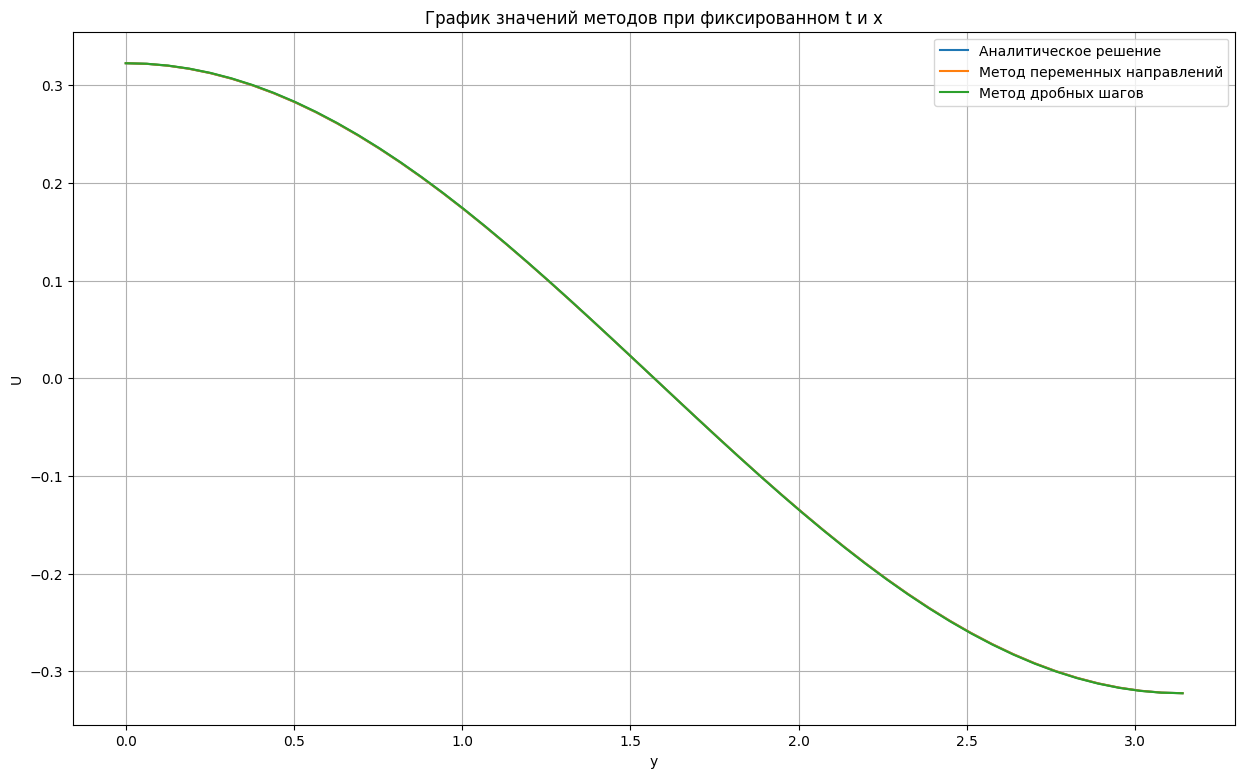

Метод переменных направлений
Модуль максимальной ошибки = 3.687504639643402e-05
Модуль средней ошибки = 9.512777759645663e-06

Метод дробных шагов
Модуль максимальной ошибки = 0.000606347807510843
Модуль средней ошибки = 0.00015825332434892168


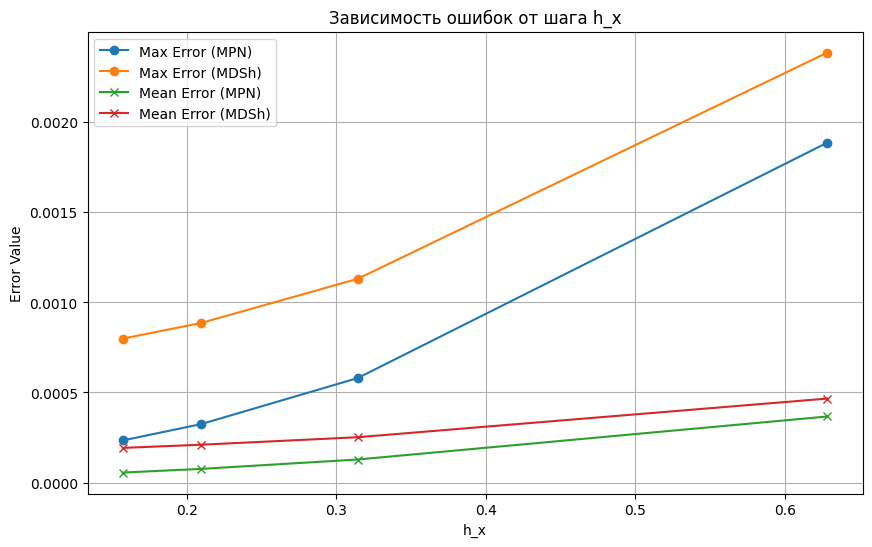

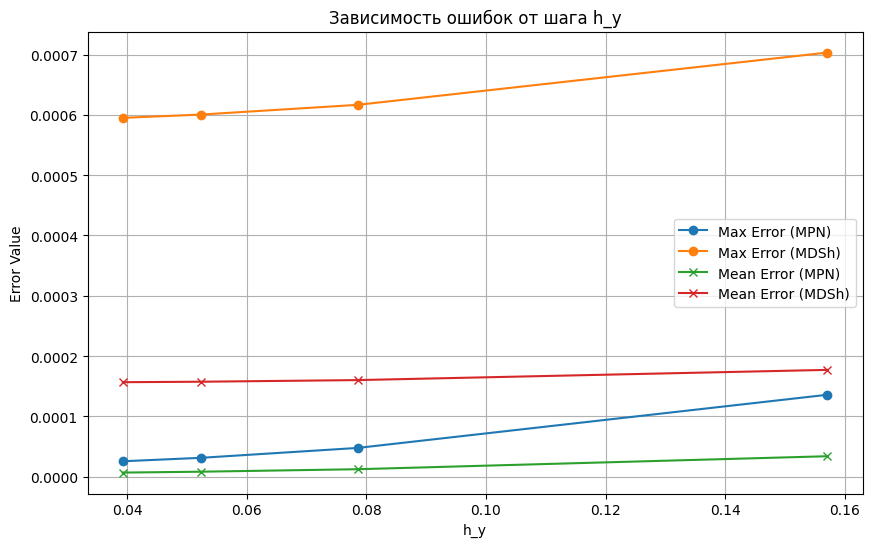

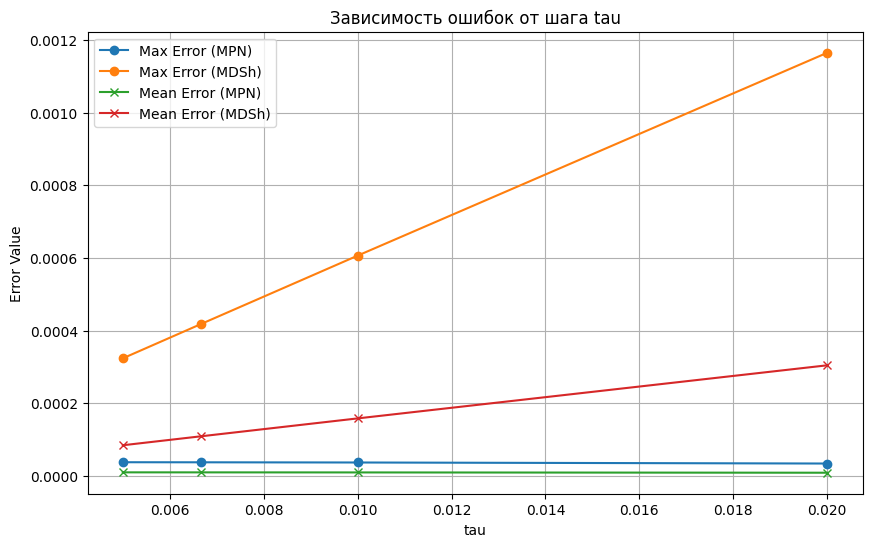

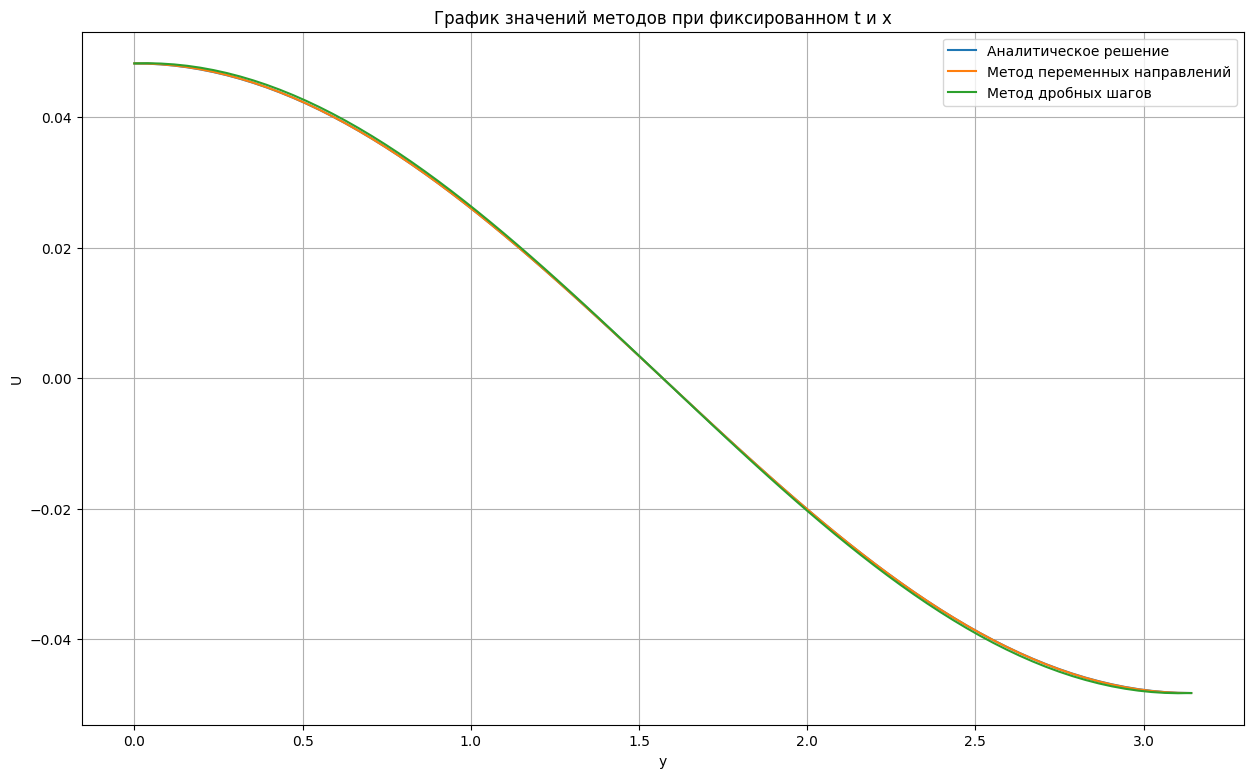

Метод переменных направлений
Модуль максимальной ошибки = 0.0016236597713813472
Модуль средней ошибки = 0.00019774402600595493

Метод дробных шагов
Модуль максимальной ошибки = 0.004513535709171901
Модуль средней ошибки = 0.0005348249661942952


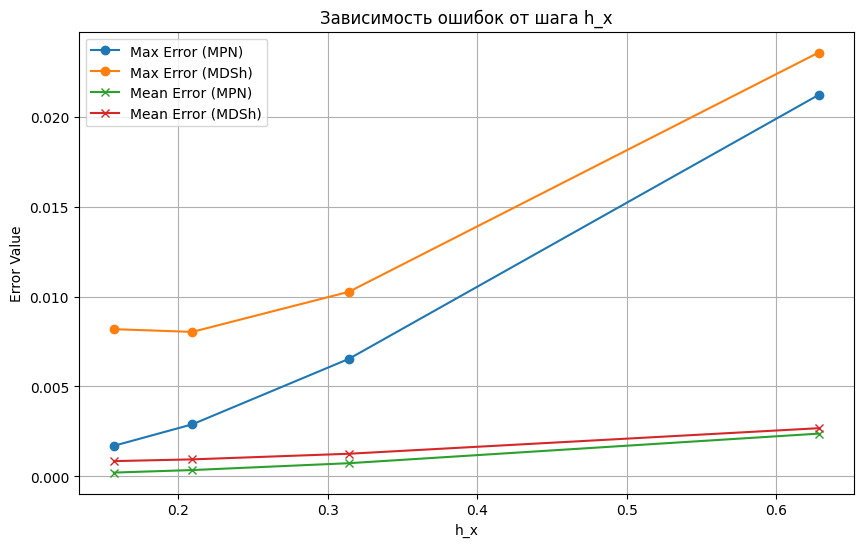

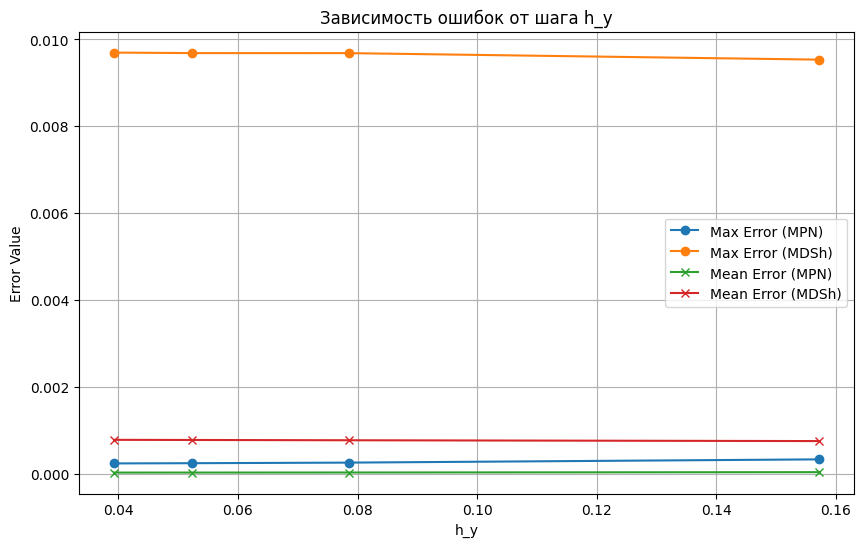

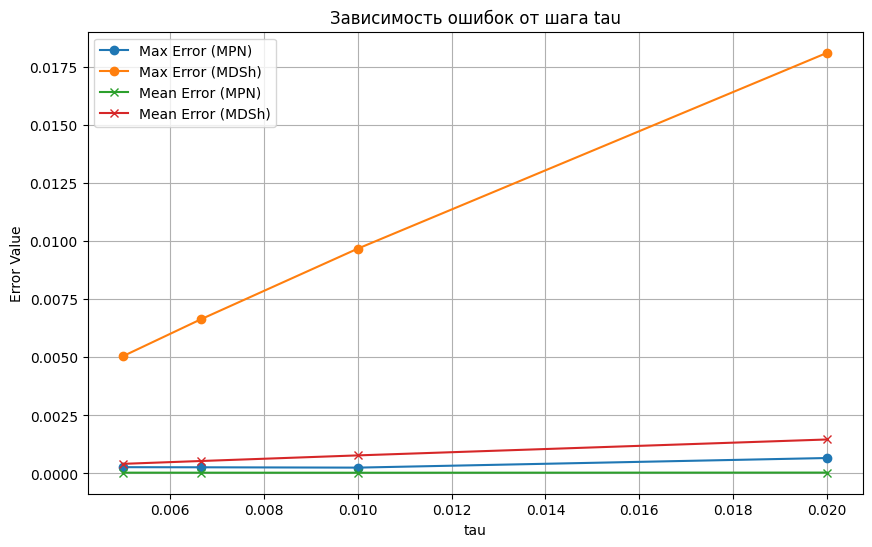

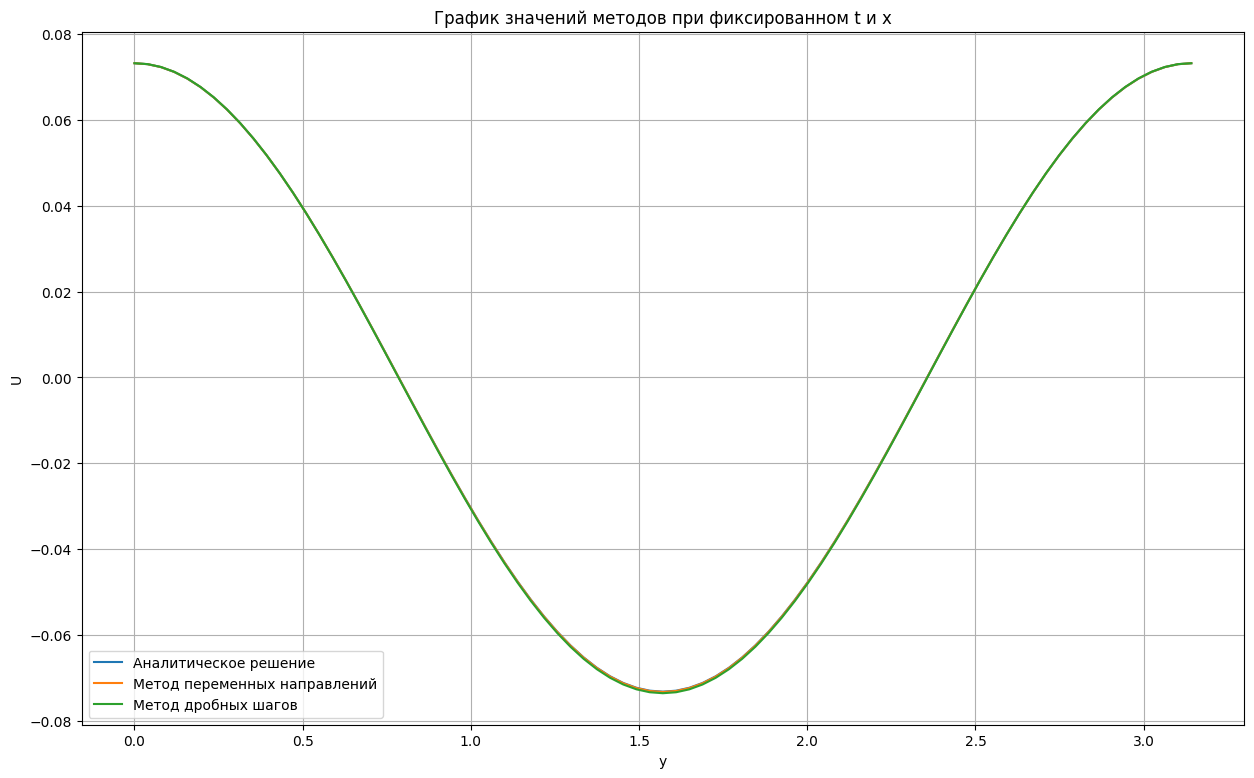

Метод переменных направлений
Модуль максимальной ошибки = 0.00020109471203427765
Модуль средней ошибки = 2.4835904487129168e-05

Метод дробных шагов
Модуль максимальной ошибки = 0.0024958612724051976
Модуль средней ошибки = 0.00018277343788900048


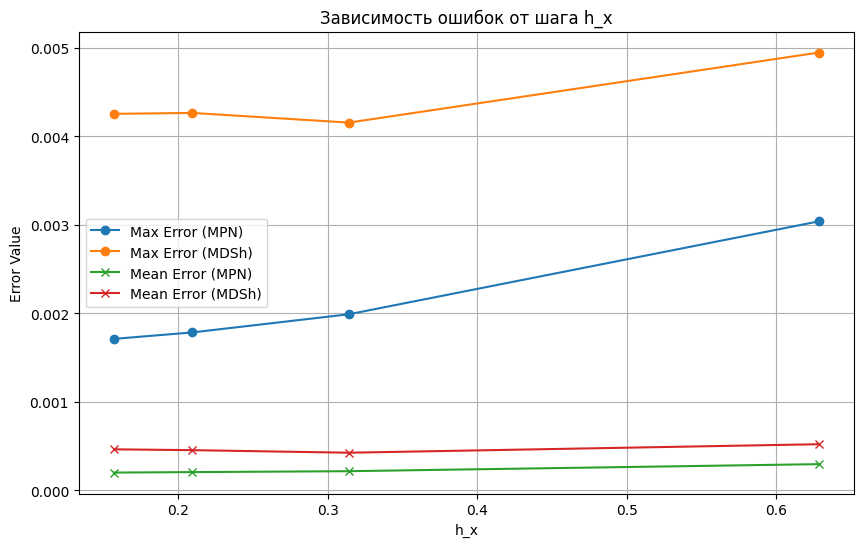

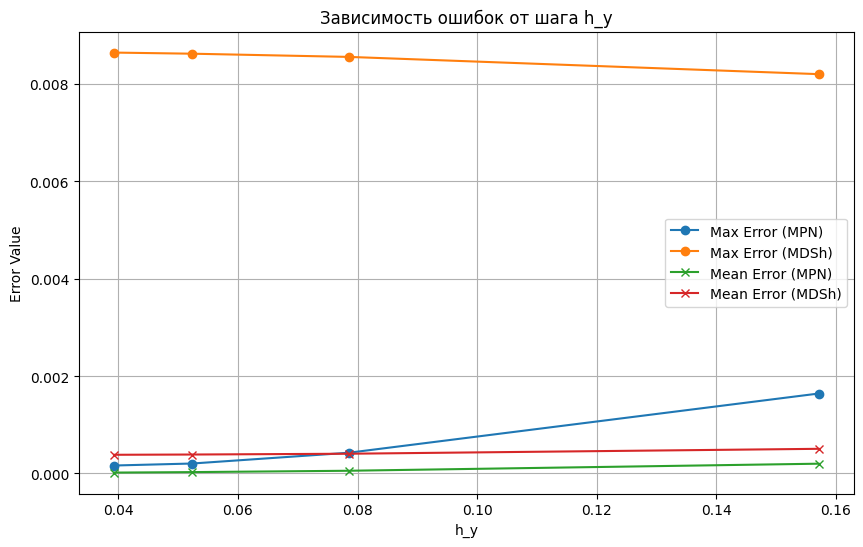

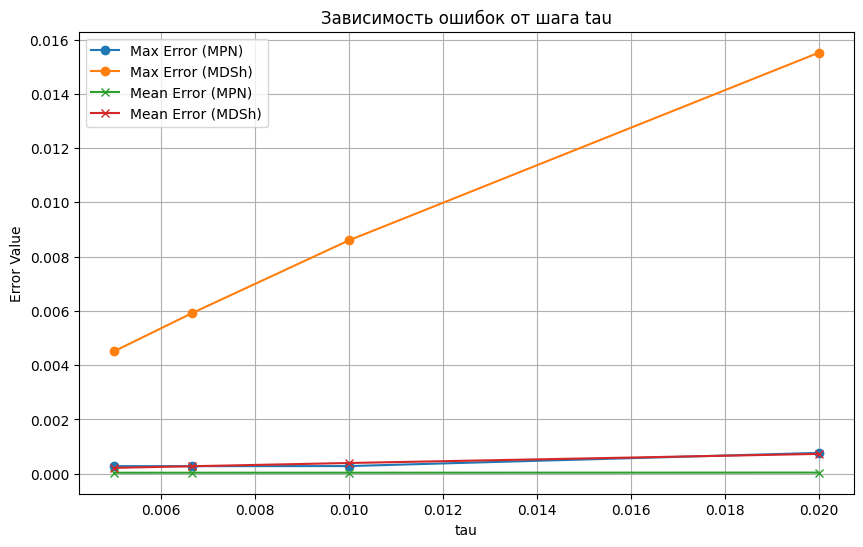

In [18]:
mu1 = 1
mu2 = 1

max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
    l_1=l_1,
    l_2=l_2,
    T=T,
    N_x=N_x,
    N_y=N_y,
    K=K,
    a=a,
    b=b,
    mu1=mu1,
    mu2=mu2,
    f=f,
    alpha_1=alpha_1,
    beta_1=beta_1,
    alpha_2=alpha_2,
    beta_2=beta_2,
    alpha_3=alpha_3,
    beta_3=beta_3,
    alpha_4=alpha_4,
    beta_4=beta_4,
    phi_1=phi_1,
    phi_2=phi_2,
    phi_3=phi_3,
    phi_4=phi_4,
    psi=psi,
    graphics=graphics,
)

print('Метод переменных направлений')
print(f'Модуль максимальной ошибки = {max_error_MPN}')
print(f'Модуль средней ошибки = {mean_error_MPN}')

print()
print('Метод дробных шагов')
print(f'Модуль максимальной ошибки = {max_error_MDSh}')
print(f'Модуль средней ошибки = {mean_error_MDSh}')

Nx_values = [5, 10, 15, 20]
Ny_values = [20, 40, 60, 80]
K_values = [50, 100, 150, 200]

errors_hx = {'max': [], 'mean': []}
errors_hy = {'max': [], 'mean': []}
errors_tau = {'max': [], 'mean': []}

for N_x in Nx_values:
    h_x = (l_1 - 0) / N_x

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=N_x,
        N_y=20,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hx['max'].append((h_x, max_error_MPN, max_error_MDSh))
    errors_hx['mean'].append((h_x, mean_error_MPN, mean_error_MDSh))

for N_y in Ny_values:
    h_y = (l_2 - 0) / N_y

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=N_y,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hy['max'].append((h_y, max_error_MPN, max_error_MDSh))
    errors_hy['mean'].append((h_y, mean_error_MPN, mean_error_MDSh))

for K in K_values:
    tau = (T - 0) / K

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=50,
        K=K,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_tau['max'].append((tau, max_error_MPN, max_error_MDSh))
    errors_tau['mean'].append((tau, mean_error_MPN, mean_error_MDSh))

def plot_errors(errors, xlabel, title):
    h_values = [item[0] for item in errors['max']]
    max_errors_MPN = [item[1] for item in errors['max']]
    max_errors_MDSh = [item[2] for item in errors['max']]
    mean_errors_MPN = [item[1] for item in errors['mean']]
    mean_errors_MDSh = [item[2] for item in errors['mean']]
    
    plt.figure(figsize=(10, 6))
    plt.plot(h_values, max_errors_MPN, label='Max Error (MPN)', marker='o')
    plt.plot(h_values, max_errors_MDSh, label='Max Error (MDSh)', marker='o')
    plt.plot(h_values, mean_errors_MPN, label='Mean Error (MPN)', marker='x')
    plt.plot(h_values, mean_errors_MDSh, label='Mean Error (MDSh)', marker='x')
    plt.xlabel(xlabel)
    plt.ylabel("Error Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_errors(errors_hx, xlabel="h_x", title="Зависимость ошибок от шага h_x")
plot_errors(errors_hy, xlabel="h_y", title="Зависимость ошибок от шага h_y")
plot_errors(errors_tau, xlabel="tau", title="Зависимость ошибок от шага tau")

mu1 = 2
mu2 = 1

max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
    l_1=l_1,
    l_2=l_2,
    T=T,
    N_x=N_x,
    N_y=N_y,
    K=K,
    a=a,
    b=b,
    mu1=mu1,
    mu2=mu2,
    f=f,
    alpha_1=alpha_1,
    beta_1=beta_1,
    alpha_2=alpha_2,
    beta_2=beta_2,
    alpha_3=alpha_3,
    beta_3=beta_3,
    alpha_4=alpha_4,
    beta_4=beta_4,
    phi_1=phi_1,
    phi_2=phi_2,
    phi_3=phi_3,
    phi_4=phi_4,
    psi=psi,
    graphics=graphics,
)

print('Метод переменных направлений')
print(f'Модуль максимальной ошибки = {max_error_MPN}')
print(f'Модуль средней ошибки = {mean_error_MPN}')

print()
print('Метод дробных шагов')
print(f'Модуль максимальной ошибки = {max_error_MDSh}')
print(f'Модуль средней ошибки = {mean_error_MDSh}')

Nx_values = [5, 10, 15, 20]
Ny_values = [20, 40, 60, 80]
K_values = [50, 100, 150, 200]

errors_hx = {'max': [], 'mean': []}
errors_hy = {'max': [], 'mean': []}
errors_tau = {'max': [], 'mean': []}

for N_x in Nx_values:
    h_x = (l_1 - 0) / N_x

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=N_x,
        N_y=20,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hx['max'].append((h_x, max_error_MPN, max_error_MDSh))
    errors_hx['mean'].append((h_x, mean_error_MPN, mean_error_MDSh))

for N_y in Ny_values:
    h_y = (l_2 - 0) / N_y

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=N_y,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hy['max'].append((h_y, max_error_MPN, max_error_MDSh))
    errors_hy['mean'].append((h_y, mean_error_MPN, mean_error_MDSh))

for K in K_values:
    tau = (T - 0) / K

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=50,
        K=K,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_tau['max'].append((tau, max_error_MPN, max_error_MDSh))
    errors_tau['mean'].append((tau, mean_error_MPN, mean_error_MDSh))

def plot_errors(errors, xlabel, title):
    h_values = [item[0] for item in errors['max']]
    max_errors_MPN = [item[1] for item in errors['max']]
    max_errors_MDSh = [item[2] for item in errors['max']]
    mean_errors_MPN = [item[1] for item in errors['mean']]
    mean_errors_MDSh = [item[2] for item in errors['mean']]
    
    plt.figure(figsize=(10, 6))
    plt.plot(h_values, max_errors_MPN, label='Max Error (MPN)', marker='o')
    plt.plot(h_values, max_errors_MDSh, label='Max Error (MDSh)', marker='o')
    plt.plot(h_values, mean_errors_MPN, label='Mean Error (MPN)', marker='x')
    plt.plot(h_values, mean_errors_MDSh, label='Mean Error (MDSh)', marker='x')
    plt.xlabel(xlabel)
    plt.ylabel("Error Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_errors(errors_hx, xlabel="h_x", title="Зависимость ошибок от шага h_x")
plot_errors(errors_hy, xlabel="h_y", title="Зависимость ошибок от шага h_y")
plot_errors(errors_tau, xlabel="tau", title="Зависимость ошибок от шага tau")

mu1 = 1
mu2 = 2

max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
    l_1=l_1,
    l_2=l_2,
    T=T,
    N_x=N_x,
    N_y=N_y,
    K=K,
    a=a,
    b=b,
    mu1=mu1,
    mu2=mu2,
    f=f,
    alpha_1=alpha_1,
    beta_1=beta_1,
    alpha_2=alpha_2,
    beta_2=beta_2,
    alpha_3=alpha_3,
    beta_3=beta_3,
    alpha_4=alpha_4,
    beta_4=beta_4,
    phi_1=phi_1,
    phi_2=phi_2,
    phi_3=phi_3,
    phi_4=phi_4,
    psi=psi,
    graphics=graphics,
)

print('Метод переменных направлений')
print(f'Модуль максимальной ошибки = {max_error_MPN}')
print(f'Модуль средней ошибки = {mean_error_MPN}')

print()
print('Метод дробных шагов')
print(f'Модуль максимальной ошибки = {max_error_MDSh}')
print(f'Модуль средней ошибки = {mean_error_MDSh}')

Nx_values = [5, 10, 15, 20]
Ny_values = [20, 40, 60, 80]
K_values = [50, 100, 150, 200]

errors_hx = {'max': [], 'mean': []}
errors_hy = {'max': [], 'mean': []}
errors_tau = {'max': [], 'mean': []}

for N_x in Nx_values:
    h_x = (l_1 - 0) / N_x

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=N_x,
        N_y=20,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hx['max'].append((h_x, max_error_MPN, max_error_MDSh))
    errors_hx['mean'].append((h_x, mean_error_MPN, mean_error_MDSh))

for N_y in Ny_values:
    h_y = (l_2 - 0) / N_y

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=N_y,
        K=100,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_hy['max'].append((h_y, max_error_MPN, max_error_MDSh))
    errors_hy['mean'].append((h_y, mean_error_MPN, mean_error_MDSh))

for K in K_values:
    tau = (T - 0) / K

    max_error_MPN, mean_error_MPN, max_error_MDSh, mean_error_MDSh = performing_a_variant_of_laboratory_work(
        l_1=l_1,
        l_2=l_2,
        T=T,
        N_x=50,
        N_y=50,
        K=K,
        a=a,
        b=b,
        mu1=mu1,
        mu2=mu2,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        psi=psi,
        graphics=False,
    )

    errors_tau['max'].append((tau, max_error_MPN, max_error_MDSh))
    errors_tau['mean'].append((tau, mean_error_MPN, mean_error_MDSh))

def plot_errors(errors, xlabel, title):
    h_values = [item[0] for item in errors['max']]
    max_errors_MPN = [item[1] for item in errors['max']]
    max_errors_MDSh = [item[2] for item in errors['max']]
    mean_errors_MPN = [item[1] for item in errors['mean']]
    mean_errors_MDSh = [item[2] for item in errors['mean']]
    
    plt.figure(figsize=(10, 6))
    plt.plot(h_values, max_errors_MPN, label='Max Error (MPN)', marker='o')
    plt.plot(h_values, max_errors_MDSh, label='Max Error (MDSh)', marker='o')
    plt.plot(h_values, mean_errors_MPN, label='Mean Error (MPN)', marker='x')
    plt.plot(h_values, mean_errors_MDSh, label='Mean Error (MDSh)', marker='x')
    plt.xlabel(xlabel)
    plt.ylabel("Error Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_errors(errors_hx, xlabel="h_x", title="Зависимость ошибок от шага h_x")
plot_errors(errors_hy, xlabel="h_y", title="Зависимость ошибок от шага h_y")
plot_errors(errors_tau, xlabel="tau", title="Зависимость ошибок от шага tau")

